# Реализация CNN для датасета CIFAR-10

CIFAR-10 имеет 10 классов объектов, изображения в разрешении размером 32х32 с RGB каналами, настройка параметров модели и обучение будет схожей с MNIST

In [14]:
# Импорт необходимых библиотек

import matplotlib.pyplot as plt
import tensorflow as tf
import random
import numpy as np

In [15]:
# Обучаемся в tensorflow 2.1.0 на GPU
print("TF Version: ", tf.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

# Иногда приходится дизейблить GPU из-за крашей ядра Jupiter. Решение проблемы пока не найдено
# tf.config.experimental.set_visible_devices([], 'GPU') 

TF Version:  2.1.0
GPU is available


In [16]:
# Параметры будущей модели

NUM_EPOCHS = 10
BATCH_SIZE = 128
NUM_CLASSES = 10
LEARNING_RATE = 0.001
INPUT_SHAPE = (32, 32, 3)

## Загрузка и подготовка датасета CIFAR-10

In [17]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = x_train.reshape(-1, 32, 32, 3).astype(np.float32) / 255.
x_test = x_test.reshape(-1, 32, 32, 3).astype(np.float32) / 255.

# применяем one-hot encoding к размеченным классам
y_train = y_train.reshape(-1).astype(np.int32)
y_test = y_test.reshape(-1).astype(np.int32)
# y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES).astype(np.int32)
# y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES).astype(np.int32)

print("train data:")
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print("test data:")
print(x_test.shape, x_test.dtype)
print(y_test.shape, y_test.dtype)

train data:
(50000, 32, 32, 3) float32
(50000,) int32
test data:
(10000, 32, 32, 3) float32
(10000,) int32


## Визуализация датасета CIFAR-10

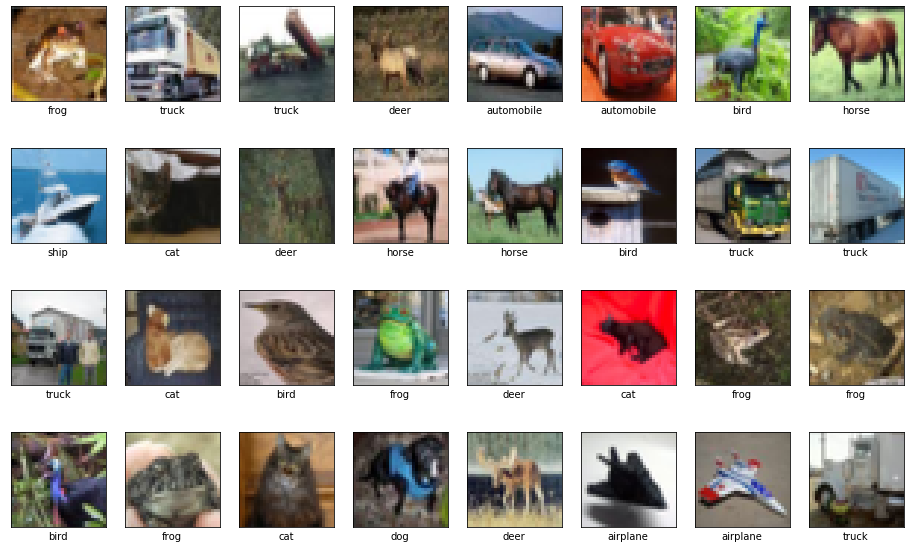

In [18]:
# Помимо метки класса полезно также отображать его наименование 
# Описание меток взято с https://www.cs.toronto.edu/~kriz/cifar.html

class_names = ["airplane", "automobile", "bird",
               "cat", "deer", "dog",
               "frog", "horse", "ship", "truck"]

some_samples = x_train[:32, ...]

fig = plt.figure(figsize=(16, 10))
for j in range(some_samples.shape[0]):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j])
    plt.xticks([]), plt.yticks([])
    plt.xlabel(class_names[y_train[j]])
plt.show()

## Создание пайплайна данных

In [24]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(buffer_size=x_train.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

## Создание модели CNN

In [25]:
class Model(tf.keras.Model):
    
    """Для CIFAR-10 будем использовать классическую сверточную архитектуру Lenet-5"""
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(6, (5, 5), activation='relu', padding='same', input_shape=INPUT_SHAPE)
        self.conv2 = tf.keras.layers.Conv2D(16, (5, 5), activation='relu', padding='same')
        self.fc1 = tf.keras.layers.Dense(120, activation='relu')
        self.fc2 = tf.keras.layers.Dense(84, activation='relu')
        self.fc3 = tf.keras.layers.Dense(NUM_CLASSES, activation=None)
        self.max_pool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2))
        self.flatten = tf.keras.layers.Flatten()
        
    def call(self, inp):

        out = self.conv1(inp)
        out = self.max_pool(out)
        out = self.conv2(out)
        out = self.max_pool(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out
    
model = Model()

## Функция потерь и функция вычисления точности

In [26]:
def loss(logits, labels):
    # print(labels)
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=labels))

def accuracy(logits, labels):
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), dtype=tf.float32))

## Подготовка к обучению

In [27]:
# optimizer = tf.keras.optimizers.SGD(LEARNING_RATE)
# optimizer = tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

# writer = tf.summary.create_file_writer('logs/sgd')
writer = tf.summary.create_file_writer('logs/adam')

## Цикл обучения модели

In [28]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        logits = model(images)
        loss_value = loss(logits, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    # Calc and display loss/accuracy
    if iteration % 500 == 0:
        test_logits = model(x_test[:256, ...])
        accuracy_value = accuracy(test_logits, y_test[:256, ...])
        
        print("[%4d] Accuracy: %5.2f %%" % (
            iteration, accuracy_value.numpy()*100))
        
        with writer.as_default():
            tf.summary.scalar('accuracy', accuracy_value, iteration)
            tf.summary.scalar('loss', loss_value, iteration)


[   0] Accuracy: 14.45 %
[ 500] Accuracy: 47.66 %
[1000] Accuracy: 57.42 %
[1500] Accuracy: 59.38 %
[2000] Accuracy: 62.11 %
[2500] Accuracy: 62.11 %
[3000] Accuracy: 57.81 %
[3500] Accuracy: 63.67 %
Wall time: 8min 48s


In [29]:
# Получившаяся модель имеет 136,886 обучаемых параметров
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            multiple                  456       
_________________________________________________________________
conv2d_5 (Conv2D)            multiple                  2416      
_________________________________________________________________
dense_6 (Dense)              multiple                  123000    
_________________________________________________________________
dense_7 (Dense)              multiple                  10164     
_________________________________________________________________
dense_8 (Dense)              multiple                  850       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten_2 (Flatten)          multiple                  0   

In [49]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 16104), started 0:01:26 ago. (Use '!kill 16104' to kill it.)

## Функция для инференса и отображения результата предсказания

In [30]:
def test_item(sample):
    
    logits = model(sample[None, ...])[0]
    prediction = tf.nn.softmax(logits)
    ans = np.argmax(prediction)   
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(sample)
    plt.xticks([]), plt.yticks([])

    ax = fig.add_subplot(1, 2, 2)
    bar_list = ax.bar(np.arange(10), prediction, align='center')
    bar_list[ans].set_color('g')
    ax.set_xticks(np.arange(10))
    ax.set_xlim([-1, 10])
    ax.grid(True)

    plt.show()
    
    print('Predicted: {} - {}'.format(ans, class_names[ans]))

## Запуск предсказания для изображения случайного изображения из CIFAR-10

В рейтинге моделей для CIFAR-10 (https://paperswithcode.com/sota/image-classification-on-cifar-10), архитектура lenet не участвует и не отличается высокой точностью.

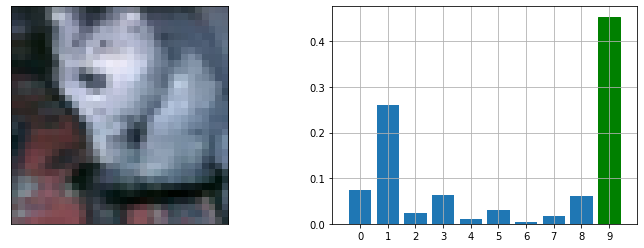

Predicted: 9 - truck
True Answer: 3 - cat


In [37]:

idx = random.randint(0, x_test.shape[0])
sample = x_test[idx, ...]
test_item(sample)

print('True Answer: {} - {}'.format(y_test[idx], class_names[y_test[idx]])) # ЭТО КОТ? НЕТ - ЭТО ЖЕ ГРУЗОВИК!

## Extra

Наблюдение выходных данных из свёрток и max-pooling слоев (для этого использована модель с построением статического графа (в graph inference доступ к узлам слоев задаются как-то иначе)

In [73]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=INPUT_SHAPE),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=2)
model.evaluate(x_test, y_test)

Train on 50000 samples
Epoch 1/2
50000/50000 [==============================] - 33s 670us/sample - loss: 1.4419 - accuracy: 0.4830
Epoch 2/2
10000/10000 [==============================] - 2s 237us/sample - loss: 1.0740 - accuracy: 0.6262


[1.0740212858200073, 0.6262]

In [151]:
# Характеристики слоев, сохраненных в графе модели
layer_outputs = [layer.output for layer in model.layers]

activation_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)


layer_outputs

[<tf.Tensor 'conv2d_12/Identity:0' shape=(None, 30, 30, 16) dtype=float32>,
 <tf.Tensor 'max_pooling2d_6/Identity:0' shape=(None, 15, 15, 16) dtype=float32>,
 <tf.Tensor 'conv2d_13/Identity:0' shape=(None, 13, 13, 64) dtype=float32>,
 <tf.Tensor 'max_pooling2d_7/Identity:0' shape=(None, 6, 6, 64) dtype=float32>,
 <tf.Tensor 'flatten_6/Identity:0' shape=(None, 2304) dtype=float32>,
 <tf.Tensor 'dense_18/Identity:0' shape=(None, 128) dtype=float32>,
 <tf.Tensor 'dense_19/Identity:0' shape=(None, 10) dtype=float32>]

In [126]:
activation_model

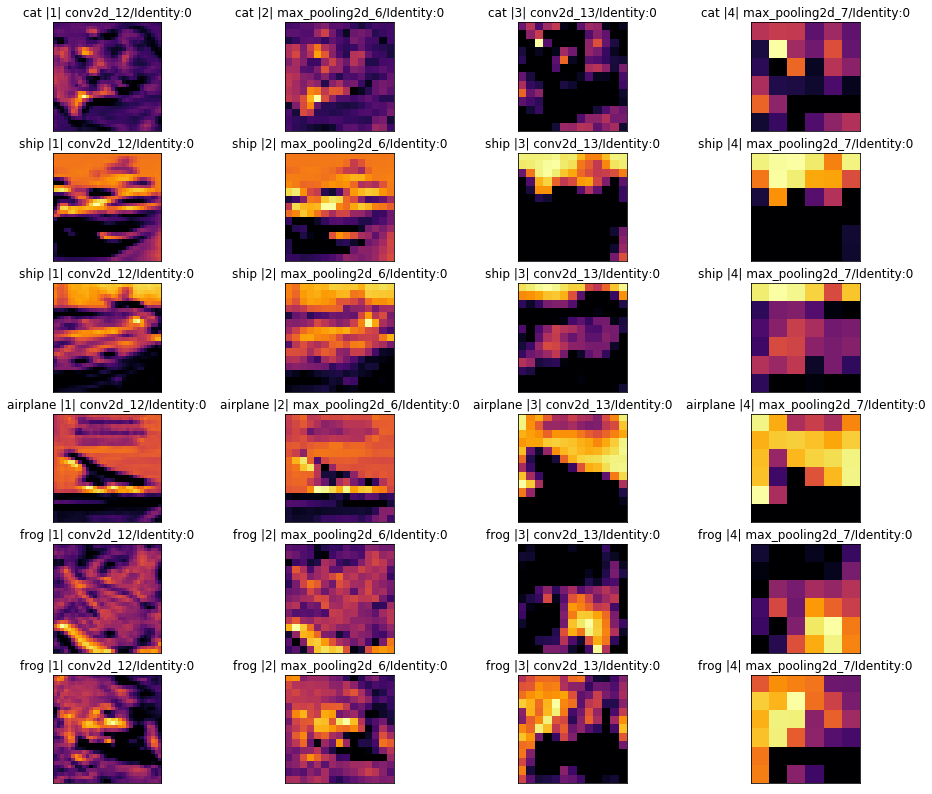

In [156]:
f, axarr = plt.subplots(6,4, figsize=(16, 14))
s = (1,)

FIRST_IMAGE=0 
SECOND_IMAGE=1 
THIRD_IMAGE=2 
FOURTH_IMAGE=3 
FIFTH_IMAGE=4 
SIXTH_IMAGE=5
CONVOLUTION_NUMBER = 1



for x in range(0,4):
    f1 = activation_model.predict(x_test[FIRST_IMAGE].reshape(s + INPUT_SHAPE))[x]
    axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
    axarr[0,x].grid(False)
    axarr[0,x].set_xticks([])
    axarr[0,x].set_yticks([])
    axarr[0,x].set_title(f'{class_names[y_test[FIRST_IMAGE]]} |{x+1}| {layer_outputs[x].name.rstrip( '/' )}')

    f2 = activation_model.predict(x_test[SECOND_IMAGE].reshape(s + INPUT_SHAPE))[x]
    axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
    axarr[1,x].grid(False)
    axarr[1,x].set_xticks([])
    axarr[1,x].set_yticks([])
    axarr[1,x].set_title(f'{class_names[y_test[SECOND_IMAGE]]} |{x+1}| {layer_outputs[x].name}')

    f3 = activation_model.predict(x_test[THIRD_IMAGE].reshape(s + INPUT_SHAPE))[x]
    axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
    axarr[2,x].grid(False)
    axarr[2,x].set_xticks([])
    axarr[2,x].set_yticks([])
    axarr[2,x].set_title(f'{class_names[y_test[THIRD_IMAGE]]} |{x+1}| {layer_outputs[x].name}')
                         
    
    f4 = activation_model.predict(x_test[FOURTH_IMAGE].reshape(s + INPUT_SHAPE))[x]
    axarr[3,x].imshow(f4[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
    axarr[3,x].grid(False)
    axarr[3,x].set_xticks([])
    axarr[3,x].set_yticks([])
    axarr[3,x].set_title(f'{class_names[y_test[FOURTH_IMAGE]]} |{x+1}| {layer_outputs[x].name}')
    
    f5 = activation_model.predict(x_test[FIFTH_IMAGE].reshape(s + INPUT_SHAPE))[x]
    axarr[4,x].imshow(f5[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
    axarr[4,x].grid(False)
    axarr[4,x].set_xticks([])
    axarr[4,x].set_yticks([])
    axarr[4,x].set_title(f'{class_names[y_test[FIFTH_IMAGE]]} |{x+1}| {layer_outputs[x].name}')              
    
    f6 = activation_model.predict(x_test[SIXTH_IMAGE].reshape(s + INPUT_SHAPE))[x]
    axarr[5,x].imshow(f6[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
    axarr[5,x].grid(False)
    axarr[5,x].set_xticks([])
    axarr[5,x].set_yticks([])
    axarr[5,x].set_title(f'{class_names[y_test[FIFTH_IMAGE]]} |{x+1}| {layer_outputs[x].name}')     
                                        

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        9280      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               295040    
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1